In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from datetime import datetime

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

kr_holidays = holidays.US(years=2019)
kr_holidays

{datetime.date(2019, 1, 21): 'Martin Luther King Jr. Day', datetime.date(2019, 2, 18): "Washington's Birthday", datetime.date(2019, 10, 14): 'Columbus Day', datetime.date(2019, 1, 1): "New Year's Day", datetime.date(2019, 5, 27): 'Memorial Day', datetime.date(2019, 7, 4): 'Independence Day', datetime.date(2019, 9, 2): 'Labor Day', datetime.date(2019, 11, 11): 'Veterans Day', datetime.date(2019, 11, 28): 'Thanksgiving', datetime.date(2019, 12, 25): 'Christmas Day'}

In [2]:
def is_weekend(date):
    return date.weekday() >= 5

def get_weekends_and_holidays(date):
    if is_weekend(date):
        return 1
    elif date in kr_holidays:
        return 1
    else:
        return 0

# Preprocessing

In [3]:
custom_info = pd.read_csv('./Customer_info.csv')
discount_info = pd.read_csv('./Discount_info.csv')
marketing_info = pd.read_csv('./Marketing_info.csv')
online_info = pd.read_csv('./Onlinesales_info.csv')
tax_info = pd.read_csv('./Tax_info.csv') # Goods and Services Tax(%)

marketing_info.columns = ['거래날짜','오프라인비용','온라인비용']
tp = {j:i+1 for i,j in zip(range(12),discount_info['월'].unique())}
discount_info['월'] = [tp[i] for i in discount_info['월']]

data = pd.merge(online_info,tax_info,on='제품카테고리')
data['월'] = data['거래날짜'].apply(lambda x:int(x.split('-')[1]))
data = pd.merge(data,custom_info,on='고객ID')
data = pd.merge(data,marketing_info,on='거래날짜')
data['거래날짜'] = pd.to_datetime(data['거래날짜'])
data['휴일'] = data['거래날짜'].apply(lambda x:get_weekends_and_holidays(x))
data = pd.merge(data,discount_info,on=['월','제품카테고리'])
data['제품ID'] = data['제품ID'].apply(lambda x:x.split('_')[1]).astype('int32')

for tar in ['수량','평균금액','배송료']:
    data[tar] = data[tar].astype('float32')
    
data = data.drop('쿠폰코드',axis=1)
for i in tqdm(range(len(data))):
    tp = data.loc[i,:]
    if tp ['쿠폰상태'] != 'Clicked':
        data.loc[i,'할인율'] = 0
        
data['지불금액'] = (data['수량']*data['평균금액'])*((100-data['할인율'])/100)+data['배송료']
data['총마케팅비용'] = data['오프라인비용'] + data['온라인비용']

data['제품카테고리'] = data['제품카테고리'].apply(lambda x:x.split('-')[0])
data['제품카테고리'] = data['제품카테고리'].replace('Bottles','Drinkware')
data['제품카테고리'] = data['제품카테고리'].replace('Housewares','Lifestyle')


data['거래날짜'] = data['거래날짜'].astype('str')

100%|██████████████████████████████████████████████████████████████████████████| 52524/52524 [00:47<00:00, 1117.29it/s]


- 휴일 데이터를 추가했다.
- 지불금액 컬럼을 생성했다. 쿠폰을 사용한경우 지불금액에서 차감되었고 계산방식은 다음과 같다. *수량 x 평균금액 x (100-할인율)/100 + 배송료*
- 제품카테고리 일부를 통합하였다.

In [4]:
data

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,GST,월,성별,고객지역,가입기간,오프라인비용,온라인비용,휴일,할인율,지불금액,총마케팅비용
0,USER_1358,Transaction_0000,2019-01-01,981,Nest,1.0,153.710007,6.5,Used,0.10,1,남,Chicago,12,4500,2424.50,1,0,160.210007,6924.50
1,USER_1358,Transaction_0001,2019-01-01,981,Nest,1.0,153.710007,6.5,Used,0.10,1,남,Chicago,12,4500,2424.50,1,0,160.210007,6924.50
2,USER_1358,Transaction_0013,2019-01-01,983,Nest,2.0,122.769997,6.5,Not Used,0.10,1,남,Chicago,12,4500,2424.50,1,0,252.039993,6924.50
3,USER_1358,Transaction_0015,2019-01-01,984,Nest,1.0,81.500000,6.5,Clicked,0.10,1,남,Chicago,12,4500,2424.50,1,10,79.850000,6924.50
4,USER_1358,Transaction_0016,2019-01-01,981,Nest,1.0,153.710007,6.5,Clicked,0.10,1,남,Chicago,12,4500,2424.50,1,10,144.839006,6924.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52519,USER_0227,Transaction_4392,2019-03-10,911,Gift Cards,1.0,250.000000,0.0,Clicked,0.05,3,여,California,8,2500,1294.22,1,30,175.000000,3794.22
52520,USER_1423,Transaction_5483,2019-03-28,910,Gift Cards,1.0,25.000000,0.0,Used,0.05,3,남,Chicago,34,2000,1066.12,0,0,25.000000,3066.12
52521,USER_0919,Transaction_18394,2019-10-06,959,Notebooks & Journals,1.0,10.800000,6.0,Clicked,0.05,10,남,California,15,3000,2230.76,1,10,15.720000,5230.76
52522,USER_0919,Transaction_18394,2019-10-06,964,Notebooks & Journals,1.0,9.600000,6.0,Used,0.05,10,남,California,15,3000,2230.76,1,0,15.600000,5230.76


In [5]:
tp = data[['고객ID','거래날짜','지불금액']].pivot_table(index='고객ID',columns='거래날짜',aggfunc='size',fill_value=0)

cols = tp.columns
rows = tp.index
for col in tqdm(range(len(cols))):
    for row in range(len(rows)):
        if tp.loc[rows[row],cols[col]] > 0:
            tp.loc[rows[row],cols[col]] = tp.loc[rows[row],cols[col]]*int(col/30)
            
r_score = tp.sum(axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [00:26<00:00, 13.80it/s]


In [6]:
rfm = pd.DataFrame(r_score,columns=['r-score'])
rfm['f-score'] = data[['고객ID','거래날짜']].groupby('고객ID').count()['거래날짜']
rfm['m-score'] = data[['고객ID','지불금액']].groupby('고객ID').sum()
rfm['m-score'] = rfm['m-score'].apply(lambda x:np.log(x))
rfm['f-score'] = rfm['f-score'].apply(lambda x:np.log(x))
rfm['r-score'] = rfm['r-score'].apply(lambda x:np.sqrt(x))
rfm

,r-score,f-score,m-score
고객ID,,,
USER_0000,4.000000,0.693147,5.198442
USER_0001,18.708287,4.077537,9.461865
USER_0002,11.789826,3.135494,7.295907
USER_0003,13.674794,2.833213,7.195961
USER_0004,16.970563,3.583519,7.575878
...,...,...,...
USER_1463,4.242641,1.791759,6.630860
USER_1464,16.031220,3.663562,7.865214
USER_1465,5.099020,2.079442,4.977616


- r-score : 1월-12월 을 0-11점으로 맵핑후 합산 후 루트스케일
- f-score : 각 사용자의 구매빈도를 카운팅 후 로그스케일
- m-score : 각 사용자의 지불금액의 합산 후 로그스케일

# Customer Segmentation & Analysis

- Segmentation 은 rfm 데이터에 TSNE 사용후 고객 밀집도를 알아본다.

In [7]:
tsne = TSNE(n_components=2, random_state=0)
tp = tsne.fit_transform(rfm)
tp = pd.DataFrame(tp,columns=['x','y'])

5


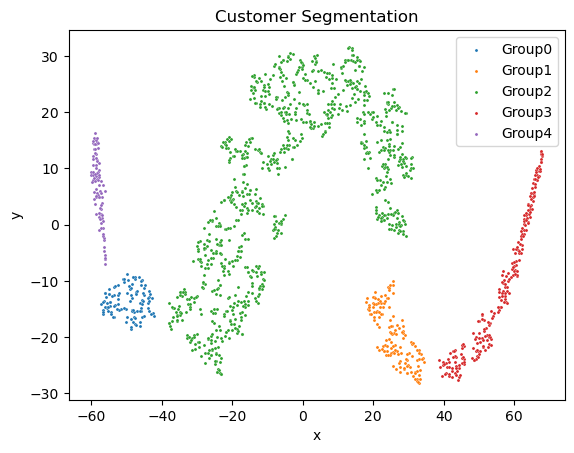

In [8]:
dbscan = DBSCAN(eps=4, min_samples=3, metric='euclidean')
prediction = dbscan.fit_predict(tp)
print(len(set(dbscan.labels_)))

tp['label'] = prediction

for i in range(-1,len(set(dbscan.labels_))):
    sns.scatterplot(data=tp[tp['label']==i],x='x',y='y',s=5, label = f'Group{i}')
    
rfm['mean_score'] = rfm.mean(axis=1)
rfm = rfm.reset_index()
rfm['group'] = prediction
rfm = rfm.rename(columns={'고객ID':'Customer ID'})
plt.title('Customer Segmentation')
plt.legend()

- rfm 데이터를 사용하여 TSNE에 넣어준후 scattering 했을때, 비선형의 5개의 큰 그룹이 형상화되어 5개의 그룹으로 쪼갤 수 있도록 DBSCAN을 수행하였다.

In [9]:
columns = ['Customer ID', 'Transaction ID', 'Transaction Date', 'Product ID', 'Product Category', 'Quantity', 'Average Amount',
       'Shipping Fee', 'Coupon Status', 'GST', 'Month', 'Gender', 'Customer Region', 'Membership Duration', 'Offline Cost', 'Online Cost', 'Holiday', 'Discount Rate',
       'Payment Amount', 'Total Marketing Cost']
data.columns = columns
grouping_data = pd.merge(data, rfm, on='Customer ID')

In [10]:
customer_group = rfm.groupby('group').mean()
# customer_group['customer_score'] = customer_group.sum(axis=1)
customer_group = customer_group.reset_index()
customer_group['counting'] = rfm[['group','Customer ID']].groupby('group').count()['Customer ID']
customer_group['group priority'] = customer_group['mean_score']*customer_group['counting']
customer_group

,group,r-score,f-score,m-score,mean_score,counting,group priority
0,0,2.569886,0.424239,4.162233,2.385453,110,262.399808
1,1,17.696972,3.803885,8.246460,9.915772,140,1388.208140
2,2,9.605514,2.779315,7.090039,6.491623,902,5855.443829
3,3,25.800332,4.508012,8.990468,13.099604,227,2973.610099
4,4,0.011236,2.351167,6.912257,3.091553,89,275.148227


- 3번 그룹은 모든 스코어가 타 그룹에비해 압도적으로 높기 때문에 필수적으로 관리해야할 고객 그룹이다. 마케팅에 즉각 반응할 확률이 높고 소비금액이 가장크다.

- 1번 그룹은 3번 그룹과 유사한 그룹이다. 시점과 빈도 사용금액 모두 우수하며 3번 그룹으로 이주시켜야할 중요한 고객층이다.

- 2번 그룹은 평볌한 그룹이며 가장 많은 고객이 있는 그룹이다. 지속적이고 적절한 금액을 소비해주는 고객층이며 플랫폼에 적응한 그룹이라고 볼 수 있다.

- 0번 그룹은 f-score 가 매우 낮다. 구매빈도를 관리해야하는 그룹이다. 하지만 m-score 또한 매우 낮기 때문에 필요한 제품만 구매하러 오는 그룹일 확률이 높다.

- 4번 그룹은 r-score 가 매우 낮다. 재유입이 필요한 그룹이다.


0,4 번 그룹의 솔루션을 진행해본다.

# Common feature

In [11]:
grouping_data.columns

Index(['Customer ID', 'Transaction ID', 'Transaction Date', 'Product ID',
       'Product Category', 'Quantity', 'Average Amount', 'Shipping Fee',
       'Coupon Status', 'GST', 'Month', 'Gender', 'Customer Region',
       'Membership Duration', 'Offline Cost', 'Online Cost', 'Holiday',
       'Discount Rate', 'Payment Amount', 'Total Marketing Cost', 'r-score',
       'f-score', 'm-score', 'mean_score', 'group'],
      dtype='object')

<AxesSubplot: xlabel='Customer Region', ylabel='Count'>

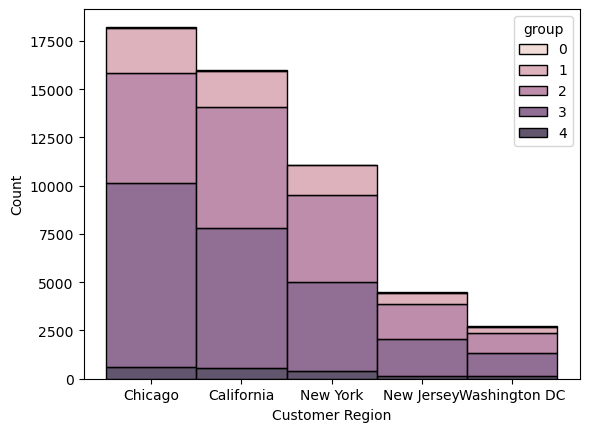

In [12]:
tp = pd.DataFrame(grouping_data[['Customer Region','group']])
sns.histplot(tp,x='Customer Region',hue='group',multiple='stack')

<AxesSubplot: xlabel='Membership Duration', ylabel='Count'>

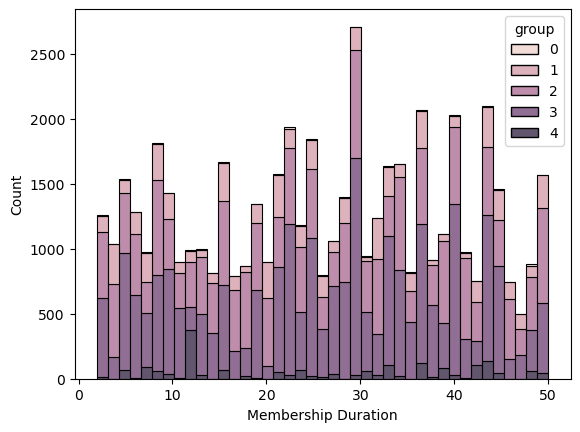

In [13]:
tp = pd.DataFrame(grouping_data[['Membership Duration','group']])
sns.histplot(tp,x='Membership Duration',hue='group',multiple='stack')

<AxesSubplot: xlabel='Gender', ylabel='Count'>

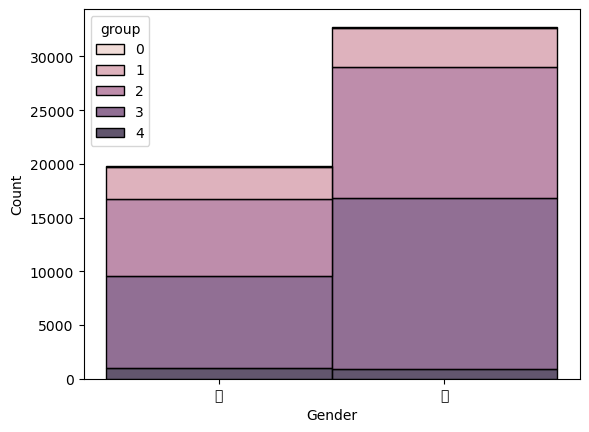

In [14]:
tp = pd.DataFrame(grouping_data[['Gender','group']])
sns.histplot(tp,x='Gender',hue='group',multiple='stack')

- 지역이나 가입기간은 특별한 특징이 없어 보인다.
- 2,3번 그룹이 상대적으로 여성이 많다.

## group 0 solution

In [15]:
grouping_data[['group','Total Marketing Cost']].groupby('group').mean()

,Total Marketing Cost
group,
0,4383.700521
1,4685.953999
2,4614.830511
3,4799.810676
4,5099.815586


- 마케팅비용을 보면 0번 그룹이 가장 취약하다는것을 알 수 있다. 따라서 0번 그룹에 효율적인 마케팅이 필요하다.

- 우선순위에 있어서 m-score가 떨어지므로 적극적인 플랫폼차원의 지원은 효율이 떨어질 수 있는 그룹이다.

## group 4 solution

In [16]:
grouping_data[['Product Category','Payment Amount']].groupby('Product Category').mean()

,Payment Amount
Product Category,
Accessories,40.573612
Android,22.989860
Apparel,39.109926
Bags,85.609325
Drinkware,64.193714
Gift Cards,114.501000
Headgear,74.803147
Lifestyle,36.372656
Nest,177.809075


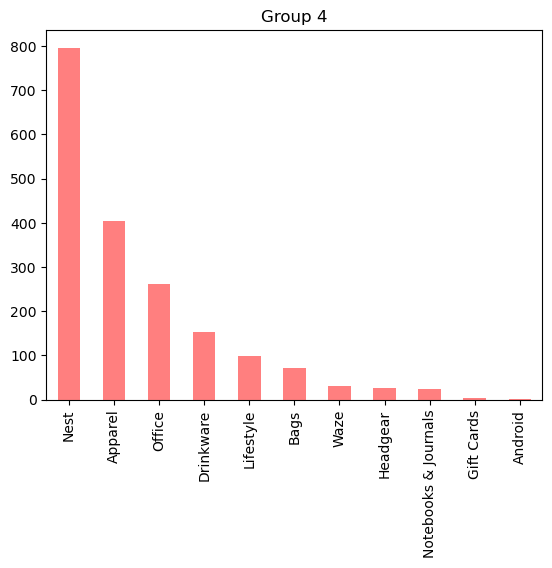

In [17]:
grouping_data[grouping_data['group'] == 4]['Product Category'].value_counts().plot.bar(color='red',alpha=0.5)
plt.title(f'Group {4}')
plt.show()

In [18]:
partial_group = grouping_data[grouping_data['group'] == 4]
partial_group[['Transaction Date','Payment Amount']].groupby('Transaction Date').sum()

,Payment Amount
Transaction Date,
2019-01-01,5000.520048
2019-01-02,5147.900109
2019-01-03,17566.861148
2019-01-04,7562.329104
2019-01-05,8333.667120
2019-01-06,8751.062098
2019-01-07,5121.837982
2019-01-08,8182.574032
2019-01-09,14037.755188


- 4 번그룹의 특징은 r-score 가 낮고 비싼 카테고리인 Nest 카테고리를 구매한 그룹이다.

- 장기적으로 플랫폼을 사용하지 않은 그룹임을 알 수 있고 마케팅 비용이 가장 높게 책정되어 있어 특정광고에 잘 노출되어 구매를 결정한 그룹일 확률이 높다.

- 사용금액 자체는 낮다고 정의하기 힘들기 때문에 적절한 이벤트로 플랫폼에 재유입시킨다면 큰 금액을 사용하는 그룹이므로 적절한 이벤트가 필요해 보인다.

# Recommendation

- group 에 따라 코사인 유사도를 사용하여 제품을 추천해준다.  

In [19]:
group_idx = 3
cols = ['Customer ID','Product ID']

co_data = grouping_data[grouping_data['group']==group_idx][cols]
user_item_matrix = co_data.groupby(cols).size().unstack(fill_value=0)
user_item_matrix[user_item_matrix > 1] = 1
user_similarity = cosine_similarity(user_item_matrix)
user_predicted_scores = user_similarity.dot(user_item_matrix) / np.array([np.abs(user_similarity).sum(axis=1)]).T

In [20]:
recommendations = []
for idx, user in enumerate(user_item_matrix.index):
    applied = set(user_item_matrix.loc[user][user_item_matrix.loc[user] == 1].index)
    sorted_indices = user_predicted_scores[idx].argsort()[::-1]
    recommended = [i for i in user_item_matrix.columns[sorted_indices] if i not in applied][:5]
    
    for i in recommended:
        recommendations.append([user, i])

In [21]:
recommedation_data = pd.DataFrame(recommendations,columns=['user','item'])
recommedation_data = pd.DataFrame(recommedation_data.groupby('user'))
recommedation_data.set_index(recommedation_data[0].apply(lambda x:int(x.split('_')[1])),inplace=True)

user_idx = 0
recommedation_data.iloc[user_idx,:][1]

,user,item
0,USER_0008,880
1,USER_0008,922
2,USER_0008,1134
3,USER_0008,195
4,USER_0008,945


# Payment Prediction

- 마케팅 데이터와 RNN을 이용하여 주요고객층(group 1,2,3)의 지불금액을 한달간 예측해본다.

Epoch 1/30
11/11 [==============================] - 8s 18ms/step - loss: 0.0586
Epoch 2/30
11/11 [==============================] - 0s 10ms/step - loss: 0.0295
Epoch 3/30
11/11 [==============================] - 0s 16ms/step - loss: 0.0202
Epoch 4/30
11/11 [==============================] - 0s 17ms/step - loss: 0.0194
Epoch 5/30
11/11 [==============================] - 0s 16ms/step - loss: 0.0169
Epoch 6/30
11/11 [==============================] - 0s 16ms/step - loss: 0.0162
Epoch 7/30
11/11 [==============================] - 0s 16ms/step - loss: 0.0165
Epoch 8/30
11/11 [==============================] - 0s 15ms/step - loss: 0.0153
Epoch 9/30
11/11 [==============================] - 0s 16ms/step - loss: 0.0151
Epoch 10/30
11/11 [==============================] - 0s 15ms/step - loss: 0.0144
Epoch 11/30
11/11 [==============================] - 0s 13ms/step - loss: 0.0141
Epoch 12/30
11/11 [==============================] - 0s 12ms/step - loss: 0.0140
Epoch 13/30
11/11 [==================

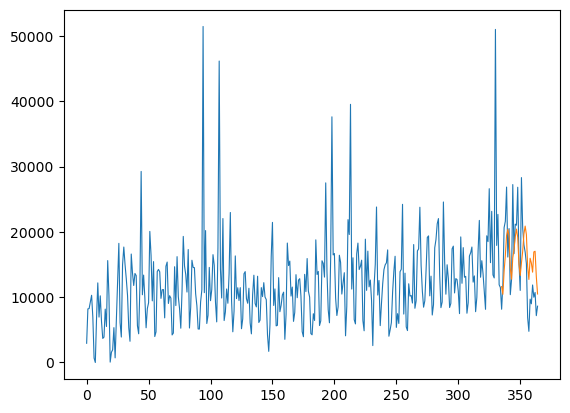

In [23]:
marketing_info = pd.read_csv('./Marketing_info.csv')
marketing_info['날짜'] = pd.to_datetime(marketing_info['날짜'])
marketing_info['Month'] = pd.to_datetime(marketing_info['날짜']).dt.month
marketing_info['Day'] = pd.to_datetime(marketing_info['날짜']).dt.day
marketing_info['휴일'] = marketing_info['날짜'].apply(lambda x:get_weekends_and_holidays(x))
marketing_info.columns = ['Transaction Date','Offline Cost','Online Cost','Month','Day','Holiday']

tp = grouping_data[(grouping_data['group'] == 1) | (grouping_data['group'] == 2) | (grouping_data['group'] == 3)][['Transaction Date','Payment Amount']]
tp = tp.groupby('Transaction Date').sum().reset_index()
tp['Transaction Date'] = pd.to_datetime(tp['Transaction Date'])
marketing_info = pd.merge(marketing_info, tp, on='Transaction Date',how='left')
marketing_info.fillna(0,inplace=True)
# marketing_info['Payment Amount'] = grouping_data[grouping_data['group'] == 1]['Payment Amount']
marketing_info = marketing_info.drop('Transaction Date',axis=1)



def normalize_data(X):
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    return X_normalized

for col in marketing_info.columns:
    marketing_info[[col]] = normalize_data(marketing_info[[col]])

def create_sequences(data, labels, seq_length, pre_cut_idx):
    sequences = []
    labels_seq = []
    label = data[labels]
    data = data.drop(labels,axis=1)
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
        labels_seq.append(label[i + seq_length - 1])
    return np.array(sequences)[:-pre_cut_idx], np.array(labels_seq)[:-pre_cut_idx],np.array(sequences)[-pre_cut_idx:], np.array(labels_seq)[-pre_cut_idx:], 
            

seq_length = 14
pre_cut_length = 30
X,y,X_test,y_test = create_sequences(marketing_info,'Payment Amount', seq_length, pre_cut_length)

model = Sequential()
model.add(LSTM(32))
model.add(Dense(1))
optimizer = Adam(lr=0.005)
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=30, verbose=1)
print('Fin.')

maxima = tp['Payment Amount'].max()
plt.plot(marketing_info['Payment Amount']*maxima,lw=0.8)
plt.plot([i for i in range(len(X)+seq_length,len(marketing_info))],model.predict(X_test)*maxima,lw=0.8)

print('MAE:',mean_absolute_error(marketing_info['Payment Amount'][-pre_cut_length:],model.predict(X_test))*maxima)

# Comment

- 수행한 Customer Segmentation 은 score scailing 과 차원축소, 밀집도를 어떻게 정하느냐에 따라 달라진다.
- TSNE로 군집이 잘 분리되어 고객분석을 해볼 수 있었다.